In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from torchvision.datasets import CIFAR100

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Step 1: Data Preparation with Label Remapping

In [11]:
# Define label mapping from CIFAR-100 to CIFAR-10
# This is a simplified mapping based on semantic similarity
# Define mapping between CIFAR-100 fine labels and CIFAR-10 labels

# Custom dataset class that applies the label mapping
# Data transformations
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class MappedCIFAR100(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.cifar100 = CIFAR100(root=root, train=train, download=True, transform=None)
        self.transform = transform
        self.classes = self.cifar100.classes  # Add this line to expose classes
        self.targets = [self.map_label(label) for label in self.cifar100.targets]  # Store mapped labels
        
    def map_label(self, label):
        # Your mapping dictionary
        cifar100_to_cifar10 = {
            10: 0, 56: 0,     # airplane
            8: 1, 58: 1,      # automobile
            13: 2, 66: 2,     # bird
            3: 3, 71: 3,      # cat
            2: 4, 91: 4,      # deer
            5: 5, 49: 5,      # dog
            92: 6, 72: 6,     # frog
            17: 7, 88: 7,     # horse
            81: 8, 94: 8,     # ship
            1: 9, 90: 9       # truck
        }
        return cifar100_to_cifar10.get(label, 2)  # default to bird (class 2) if not in mapping
    
    def __getitem__(self, index):
        img, label = self.cifar100[index]
        mapped_label = self.map_label(label)
        if self.transform:
            img = self.transform(img)
        return img, mapped_label
    
    def __len__(self):
        return len(self.cifar100)


# CIFAR-10 classes
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']



In [12]:
# Load CIFAR-100 to get class names

cifar100_train = CIFAR100(root='./data', train=True, download=True)
cifar100_classes = cifar100_train.classes

In [13]:
# Load datasets with the new mapping
source_train = MappedCIFAR100(root='./data', train=True, transform=transform)
source_test = MappedCIFAR100(root='./data', train=False, transform=transform)

target_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
target_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 128
source_train_loader = DataLoader(source_train, batch_size=batch_size, shuffle=True)
source_test_loader = DataLoader(source_test, batch_size=batch_size, shuffle=False)

target_train_loader = DataLoader(target_train, batch_size=batch_size, shuffle=True)
target_test_loader = DataLoader(target_test, batch_size=batch_size, shuffle=False)

In [14]:
# Now you can access the classes
print("Original CIFAR-100 classes:", source_train.classes)

# To see which CIFAR-100 classes are actually used in your mapping:
used_indices = set([10, 56, 8, 58, 13, 66, 3, 71, 2, 91, 5, 49, 92, 72, 17, 88, 81, 94, 1, 90])
used_classes = [source_train.classes[i] for i in used_indices]

print("\nCIFAR-100 classes actually used in mapping:")
for idx, class_name in zip(used_indices, used_classes):
    print(f"{idx}: {class_name}")

print(f"\nTotal used CIFAR-100 classes: {len(used_indices)}")

Original CIFAR-100 classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardro

In [24]:
# Verification code
cifar100_to_cifar10 = {
    10: 0, 56: 0,     # airplane
    8: 1, 58: 1,      # automobile
    13: 2, 66: 2,     # bird
    3: 3, 71: 3,      # cat
    2: 4, 91: 4,      # deer
    5: 5, 49: 5,      # dog
    92: 6, 72: 6,     # frog
    17: 7, 88: 7,     # horse
    81: 8, 94: 8,     # ship
    1: 9, 90: 9       # truck
}
def verify_mapping():
    # Load CIFAR-100 to get class names
    cifar100 = datasets.CIFAR100(root='./data', train=True, download=True)
    cifar100_classes = cifar100.classes
    
    print("Verifying label mapping:")
    print("{:<30} {:<15} {}".format("CIFAR-100 Class", "CIFAR-100 ID", "CIFAR-10 Class"))
    
    for cifar100_id, cifar10_id in cifar100_to_cifar10.items():
        print("{:<30} {:<15} {}".format(
            cifar100_classes[cifar100_id],
            cifar100_id,
            cifar10_classes[cifar10_id]
        ))

verify_mapping()

Verifying label mapping:
CIFAR-100 Class                CIFAR-100 ID    CIFAR-10 Class
bowl                           10              airplane
palm_tree                      56              airplane
bicycle                        8               automobile
pickup_truck                   58              automobile
bus                            13              bird
raccoon                        66              bird
bear                           3               cat
sea                            71              cat
baby                           2               deer
trout                          91              deer
bed                            5               dog
mountain                       49              dog
tulip                          92              frog
seal                           72              frog
castle                         17              horse
tiger                          88              horse
streetcar                      81              ship
wardrobe   

### Step 2: DANN Model Implementation

In [25]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
    def forward(self, x):
        return self.conv_layers(x)


In [26]:
class LabelClassifier(nn.Module):
    def __init__(self):
        super(LabelClassifier, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 5 * 5, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc_layers(x)

class DomainClassifier(nn.Module):
    def __init__(self):
        super(DomainClassifier, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 5 * 5, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1)
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return torch.sigmoid(self.fc_layers(x))

In [27]:
class DANN(nn.Module):
    def __init__(self):
        super(DANN, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.label_classifier = LabelClassifier()
        self.domain_classifier = DomainClassifier()
        
    def forward(self, x, alpha=0):
        features = self.feature_extractor(x)
        
        # Reverse the gradient for the domain classifier
        reverse_features = GradientReversal.apply(features, alpha)
        
        label_output = self.label_classifier(features)
        domain_output = self.domain_classifier(reverse_features)
        
        return label_output, domain_output


In [28]:
# Gradient reversal layer
class GradientReversal(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None


### Step 3: Training with Domain Adaptation

In [29]:
def train_dann(model, source_loader, target_loader, num_epochs=30):
    print("Initializing training...")  # Debug print
    model = model.to(device)
    
    # Loss functions
    label_criterion = nn.CrossEntropyLoss()
    domain_criterion = nn.BCELoss()
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
    
    history = {
        'epoch': [],
        'source_loss': [],
        'target_loss': [],
        'source_acc': [],
        'target_acc': []
    }
    
    print(f"Starting training for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")  # Debug print
        model.train()
        running_label_loss = 0.0
        running_domain_loss = 0.0
        correct_label = 0
        total_label = 0
        correct_domain = 0
        total_domain = 0
        
        p = epoch / num_epochs
        alpha = 2. / (1. + np.exp(-10 * p)) - 1
        
        # Debug: Print data loader lengths
        print(f"Source loader batches: {len(source_loader)}, Target loader batches: {len(target_loader)}")
        
        min_len = min(len(source_loader), len(target_loader))
        source_iter = iter(source_loader)
        target_iter = iter(target_loader)
        
        for batch_idx in range(min_len):
            if batch_idx % 60 == 0:  # Print progress every 10 batches
                print(f"Processing batch {batch_idx}/{min_len}")
            
            try:
                # Source domain data
                source_data, source_labels = next(source_iter)
                source_data = source_data.to(device)
                source_labels = source_labels.to(device)
                
                # Target domain data
                target_data, _ = next(target_iter)
                target_data = target_data.to(device)
                
                # Combined data
                combined_data = torch.cat([source_data, target_data], dim=0)
                domain_labels = torch.cat([
                    torch.ones(source_labels.size(0)),
                    torch.zeros(target_data.size(0))
                ]).to(device)
                
                # Forward pass
                label_outputs, domain_outputs = model(combined_data, alpha)
                source_label_outputs = label_outputs[:source_labels.size(0)]
                
                # Calculate losses
                label_loss = label_criterion(source_label_outputs, source_labels)
                domain_loss = domain_criterion(domain_outputs.squeeze(), domain_labels)
                total_loss = label_loss + domain_loss
                
                # Backward and optimize
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()
                
                # Statistics
                running_label_loss += label_loss.item()
                running_domain_loss += domain_loss.item()
                
                # Label accuracy
                _, predicted = torch.max(source_label_outputs.data, 1)
                total_label += source_labels.size(0)
                correct_label += (predicted == source_labels).sum().item()
                
                # Domain accuracy
                predicted_domains = (domain_outputs.squeeze() > 0.5).float()
                total_domain += domain_labels.size(0)
                correct_domain += (predicted_domains == domain_labels).sum().item()
                
            except Exception as e:
                print(f"Error in batch {batch_idx}: {str(e)}")
                raise
        
        # Update learning rate
        scheduler.step()
        
        # Calculate epoch statistics
        epoch_label_loss = running_label_loss / min_len
        epoch_domain_loss = running_domain_loss / min_len
        epoch_label_acc = 100 * correct_label / total_label
        epoch_domain_acc = 100 * correct_domain / total_domain
        
        # Evaluate on target test set
        target_acc = evaluate_target(model, target_test_loader)
        
        # Store history
        history['epoch'].append(epoch + 1)
        history['source_loss'].append(epoch_label_loss)
        history['target_loss'].append(epoch_domain_loss)
        history['source_acc'].append(epoch_label_acc)
        history['target_acc'].append(target_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Label Loss: {epoch_label_loss:.4f}, '
              f'Domain Loss: {epoch_domain_loss:.4f}, '
              f'Source Acc: {epoch_label_acc:.2f}%, '
              f'Target Acc: {target_acc:.2f}%')
    
    return history

In [30]:
print("Source loader length:", len(source_train_loader))
print("Target loader length:", len(target_train_loader))

# Test one batch
source_batch = next(iter(source_train_loader))
print("Source batch shapes:", source_batch[0].shape, source_batch[1].shape)
target_batch = next(iter(target_train_loader))
print("Target batch shapes:", target_batch[0].shape, target_batch[1].shape)

Source loader length: 391
Target loader length: 391
Source batch shapes: torch.Size([128, 3, 32, 32]) torch.Size([128])
Target batch shapes: torch.Size([128, 3, 32, 32]) torch.Size([128])


In [31]:
def evaluate_target(model, target_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in target_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

### Step 4:Train the model

In [32]:

from torchinfo import summary


# Initialize and train the model

dann_model = DANN()

# Call summary with multi-input: [image_tensor, alpha]
summary(dann_model)

Layer (type:depth-idx)                   Param #
DANN                                     --
├─FeatureExtractor: 1-1                  --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  4,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─MaxPool2d: 3-3               --
│    │    └─ReLU: 3-4                    --
│    │    └─Conv2d: 3-5                  204,928
│    │    └─BatchNorm2d: 3-6             256
│    │    └─MaxPool2d: 3-7               --
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  295,168
│    │    └─BatchNorm2d: 3-10            512
│    │    └─ReLU: 3-11                   --
│    │    └─Conv2d: 3-12                 590,080
│    │    └─BatchNorm2d: 3-13            512
│    │    └─ReLU: 3-14                   --
│    │    └─Conv2d: 3-15                 590,080
│    │    └─BatchNorm2d: 3-16            512
│    │    └─ReLU: 3-17                   --
├─LabelClassifier: 1-2                   --

In [33]:
history = train_dann(dann_model, source_train_loader, target_train_loader, num_epochs=30)

Initializing training...
Starting training for 30 epochs...

Epoch 1/30
Source loader batches: 391, Target loader batches: 391
Processing batch 0/391
Processing batch 60/391
Processing batch 120/391
Processing batch 180/391
Processing batch 240/391
Processing batch 300/391
Processing batch 360/391
Epoch [1/30], Label Loss: 0.8343, Domain Loss: 0.6698, Source Acc: 81.67%, Target Acc: 10.07%

Epoch 2/30
Source loader batches: 391, Target loader batches: 391
Processing batch 0/391
Processing batch 60/391
Processing batch 120/391
Processing batch 180/391
Processing batch 240/391
Processing batch 300/391
Processing batch 360/391
Epoch [2/30], Label Loss: 0.7324, Domain Loss: 0.6565, Source Acc: 82.18%, Target Acc: 10.94%

Epoch 3/30
Source loader batches: 391, Target loader batches: 391
Processing batch 0/391
Processing batch 60/391
Processing batch 120/391
Processing batch 180/391
Processing batch 240/391
Processing batch 300/391
Processing batch 360/391
Epoch [3/30], Label Loss: 0.6676, D

### Step 5: Visualization

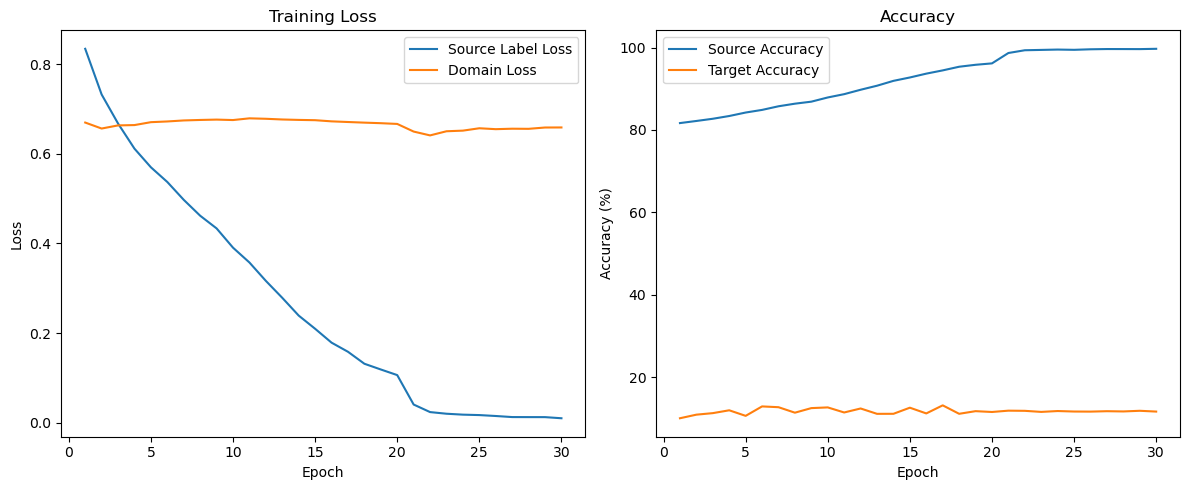

In [34]:

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['epoch'], history['source_loss'], label='Source Label Loss')
plt.plot(history['epoch'], history['target_loss'], label='Domain Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['epoch'], history['source_acc'], label='Source Accuracy')
plt.plot(history['epoch'], history['target_acc'], label='Target Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [35]:
# t-SNE Visualization
def extract_features(model, data_loader):
    model.eval()
    features = []
    labels = []
    domains = []
    with torch.no_grad():
        for images, lbls in data_loader:
            images = images.to(device)
            feats = model.feature_extractor(images)
            feats = feats.view(feats.size(0), -1)
            features.append(feats.cpu().numpy())
            labels.append(lbls.numpy())
            domains.append(np.zeros(len(lbls)))  # 0 for target (CIFAR-10)
            
        # Add some source samples for comparison
        source_iter = iter(source_test_loader)
        for _ in range(5):  # Just take 5 batches of source data
            src_images, src_lbls = next(source_iter)
            src_images = src_images.to(device)
            src_feats = model.feature_extractor(src_images)
            src_feats = src_feats.view(src_feats.size(0), -1)
            features.append(src_feats.cpu().numpy())
            labels.append(src_lbls.numpy())
            domains.append(np.ones(len(src_lbls)))  # 1 for source (CIFAR-100)
    
    return np.concatenate(features), np.concatenate(labels), np.concatenate(domains)

In [36]:
# Extract features
features, labels, domains = extract_features(dann_model, target_test_loader)

# Subsample for t-SNE (it's computationally expensive)
sample_size = 2000
indices = np.random.choice(len(features), sample_size, replace=False)
features_sample = features[indices]
labels_sample = labels[indices]
domains_sample = domains[indices]

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features_sample)

In [37]:
# Plot t-SNE results
plt.figure(figsize=(12, 5))


<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 't-SNE Visualization by Class')

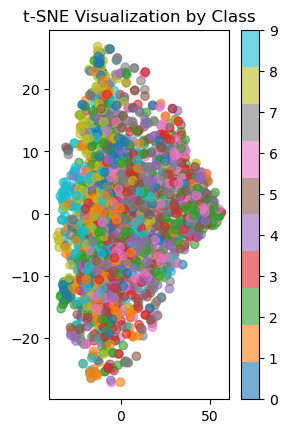

In [38]:
# Plot by class
plt.subplot(1, 2, 1)
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels_sample, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, ticks=range(10))
plt.title('t-SNE Visualization by Class')


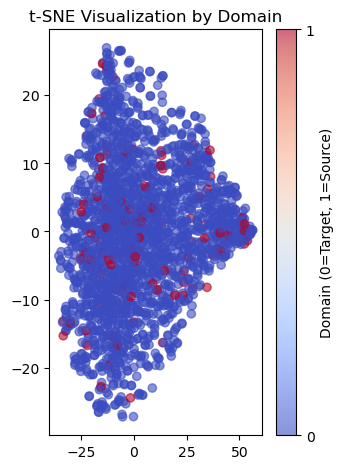

In [39]:
# Plot by domain
plt.subplot(1, 2, 2)
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=domains_sample, cmap='coolwarm', alpha=0.6)
plt.colorbar(scatter, ticks=[0, 1], label='Domain (0=Target, 1=Source)')
plt.title('t-SNE Visualization by Domain')

plt.tight_layout()
plt.show()


In [40]:
# Confusion Matrix
def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs, _ = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    return np.array(all_preds), np.array(all_labels)

preds, true_labels = get_predictions(dann_model, target_test_loader)


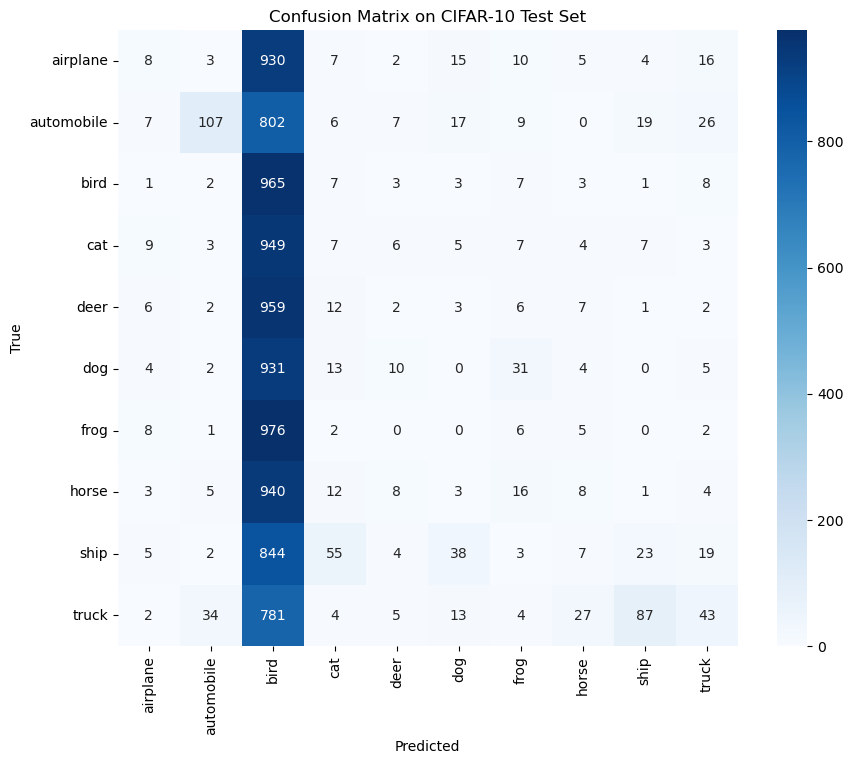

In [41]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on CIFAR-10 Test Set')
plt.show()